In [1]:
import numpy as np
import scipy as sp
import pylab as plt

import cosmolopy

In [2]:
omegam, omegab, h, sigma_8, ns = (0.315, 0.0487, 0.673, 0.83, 0.960) ##Planck-13
cosmo = cosmolopy.fidcosmo
cosmo.update({'omega_M_0':omegam, 'omega_lambda_0':1 - omegam, 'omega_k_0':0.0, 'omega_b_0':omegab, 'h':h, 'n':ns, 'sigma_8':sigma_8})

In [42]:
Mmin = 1.e8
zeta = 10.0
clumping = 3.0

In [43]:
z_arr = np.linspace(30.0, 0.0, num=300)
fcoll_arr = cosmolopy.perturbation.collapse_fraction(*cosmolopy.perturbation.sig_del(Mmin, z_arr, passed_min_mass=True, **cosmo)) 
## crucial to include passed_min_mass


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2197: RuntimeWarning: overflow encountered in _vec_transfer_func (vectorized)
  outputs = ufunc(*inputs)


In [44]:
def dP_dz(P_z, z, clumping, zeta, cosmo):
    T0 = 1.e4
    alpha_B = cosmolopy.reionization.recomb_rate_coeff_HG(T0, 'H', 'B')
    ignore, ignore, ignore, n_H_0 = cosmolopy.density.baryon_densities(**cosmo)
    n_H_0 = n_H_0  / cosmolopy.cc.Mpc_cm ** 3  ### change units
    
    fcoll = cosmolopy.perturbation.collapse_fraction(*cosmolopy.perturbation.sig_del(Mmin, z, passed_min_mass=True, **cosmo))
    recomb_term = - clumping * alpha_B * n_H_0 * (1. + z) ** 3. / (cosmolopy.distance.hubble_z(z, **cosmo) * (1. + z))
    
    return - recomb_term * (P_z + zeta * fcoll)

In [55]:
P_arr = sp.integrate.odeint(dP_dz, y0=0.0, t=z_arr, args=(clumping, zeta, cosmo))
P_arr = P_arr.flatten()  ### flatten the 2-d array
Q_arr = P_arr + zeta * fcoll_arr
Q_arr[Q_arr > 1.0] = 1.0
z_end = z_arr[np.argmax(Q_arr == 1.0)]

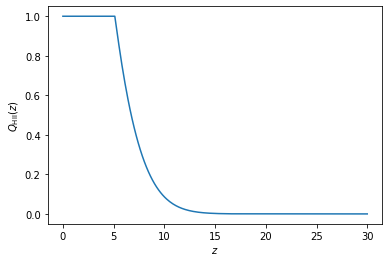

In [56]:
plt.plot(z_arr, Q_arr)
plt.xlabel(r'$z$')
plt.ylabel(r'$Q_{\mathrm{HII}}(z)$')
plt.show()

In [57]:
x_ionHe_arr = np.zeros_like(Q_arr)
tau_arr = cosmolopy.reionization.integrate_optical_depth(Q_arr[::-1], x_ionHe_arr, z_arr[::-1], **cosmo)
tau_arr = tau_arr[::-1]
print (tau_arr[0])

0.04553865926592815


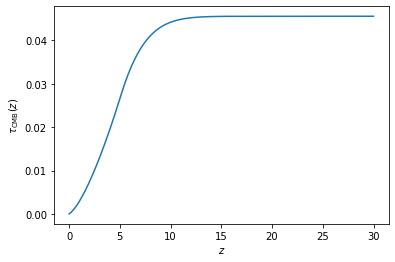

In [58]:
plt.plot(z_arr, tau_arr)
plt.xlabel(r'$z$')
plt.ylabel(r'$\tau_{\mathrm{CMB}}(z)$')
plt.show()